## Vehicles: Object Detection

Dataset Source: https://huggingface.co/datasets/Francesco/vehicles-q0x2v

#### Install Necessary Libraries

In [1]:
%pip install pip --upgrade
%pip install datasets pytorch-lightning timm
%pip install evaluate tensorboard transformers
%pip install albumentations
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/66/f8/38298237d18d4b6a8ee5dfe390e97bed5adb8e01ec6f9680c0ddf3066728/datasets-2.14.4-py3-none-any.whl.metadata
  Obtaining dependency information for pytorch-lightning from https://files.pythonhosted.org/packages/d5/ef/39994adec1fe1d5f25fd0dd0a82abcd8bd61fc968283790b9da7463f0279/pytorch_lightning-2.0.7-py3-none-any.whl.metadata
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/14/38/05b37b7692e521bbada22593ac3b6d7ba3f378d56b5d1ccb322a541bbb6e/timm-0.9.5-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 3.0 MB/s eta 0:00:00
  Obtaining dependency information for dill<0.3.8,>=0.3.0 from https://files.pythonh

#### Enter Huggingface Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Necessary Libraries

In [4]:
import os, sys, random, shutil, re, json

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import PIL.Image

from tqdm import tqdm

import datasets
from datasets import load_dataset

import torch
import torchvision

import transformers
from transformers import AutoImageProcessor, TrainingArguments
from transformers import AutoModelForObjectDetection, Trainer

import albumentations

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Libraries

In [5]:
library_len = 14
version_len = 7

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|", "Library".rjust(library_len), "|", "Version".ljust(version_len), "|")
print(f"|{'*' * (library_len + version_len + 5)}|")
print("|", "Python".rjust(library_len), "|", sys.version[0:6].ljust(version_len), "|")
print("|", "NumPy".rjust(library_len), "|", np.__version__.ljust(version_len), "|")
print("|", "Torch".rjust(library_len), "|", torch.__version__.ljust(version_len), "|")
print("|", "Torch Vision".rjust(library_len), "|", torchvision.__version__.ljust(version_len), "|")
print("|", "Datasets".rjust(library_len), "|", datasets.__version__.ljust(version_len), "|")
print("|", "Albumentations".rjust(library_len), "|", albumentations.__version__.ljust(version_len), "|")
print("|", "Transformer".rjust(library_len), "|", transformers.__version__.ljust(version_len), "|")
print("|", "Evaluate".rjust(library_len), "|", evaluate.__version__.ljust(version_len), "|")
print(f"+{'-' * (library_len + version_len + 5)}+")

+--------------------------+
|        Library | Version |
|**************************|
|         Python | 3.10.1  |
|          NumPy | 1.23.5  |
|          Torch | 2.0.1+cu118 |
|   Torch Vision | 0.15.2+cu118 |
|       Datasets | 2.14.4  |
| Albumentations | 1.3.1   |
|    Transformer | 4.31.0  |
|       Evaluate | 0.4.0   |
+--------------------------+


#### Load Dataset

In [6]:
data = load_dataset("Francesco/vehicles-q0x2v")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2634
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 458
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 966
    })
})

#### Display Features for Sample

In [7]:
data['train'][12]

{'image_id': 1769,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [21399,
   21400,
   21401,
   21402,
   21403,
   21404,
   21405,
   21406,
   21407,
   21408,
   21409,
   21410,
   21411,
   21412,
   21413,
   21414,
   21415,
   21416,
   21417,
   21418,
   21419,
   21420,
   21421,
   21422,
   21423,
   21424],
  'area': [430,
   1105,
   530,
   472,
   586,
   793,
   612,
   672,
   671,
   672,
   992,
   1400,
   884,
   1445,
   1767,
   1193,
   11270,
   3078,
   5460,
   2357,
   7600,
   6196,
   4123,
   5628,
   27590,
   7448],
  'bbox': [[304.0, 260.0, 20.0, 21.5],
   [361.0, 251.0, 26.0, 42.5],
   [218.0, 260.0, 20.0, 26.5],
   [248.0, 268.0, 21.0, 22.5],
   [339.0, 267.0, 23.0, 25.5],
   [178.0, 267.0, 26.0, 30.5],
   [205.0, 280.0, 24.0, 25.5],
   [245.0, 288.0, 24.0, 28.0],
   [311.0, 292.0, 22.0, 30.5],
   [193.0, 302.0, 24.0, 28.0],
   [137.0, 302.0, 31.0, 32.0],
   [394.0, 300

#### Define List of Category Names & Conversion Dictionaries

In [8]:
categories = data["train"].features["objects"].feature["category"].names

NUM_OF_CATEGORIES = len(categories)

id2label = {idx: tag for idx, tag in enumerate(categories)}
label2id = {tag: idx for idx, tag in enumerate(categories)}

print(f"List of Category Names:\n{categories}")
print(f"Number of Category Names: {NUM_OF_CATEGORIES}")
print(f"id2label:\n{id2label}")
print(f"label2id:\n{label2id}")

List of Category Names:
['vehicles', 'big bus', 'big truck', 'bus-l-', 'bus-s-', 'car', 'mid truck', 'small bus', 'small truck', 'truck-l-', 'truck-m-', 'truck-s-', 'truck-xl-']
Number of Category Names: 13
id2label:
{0: 'vehicles', 1: 'big bus', 2: 'big truck', 3: 'bus-l-', 4: 'bus-s-', 5: 'car', 6: 'mid truck', 7: 'small bus', 8: 'small truck', 9: 'truck-l-', 10: 'truck-m-', 11: 'truck-s-', 12: 'truck-xl-'}
label2id:
{'vehicles': 0, 'big bus': 1, 'big truck': 2, 'bus-l-': 3, 'bus-s-': 4, 'car': 5, 'mid truck': 6, 'small bus': 7, 'small truck': 8, 'truck-l-': 9, 'truck-m-': 10, 'truck-s-': 11, 'truck-xl-': 12}


#### Visualize A Sample

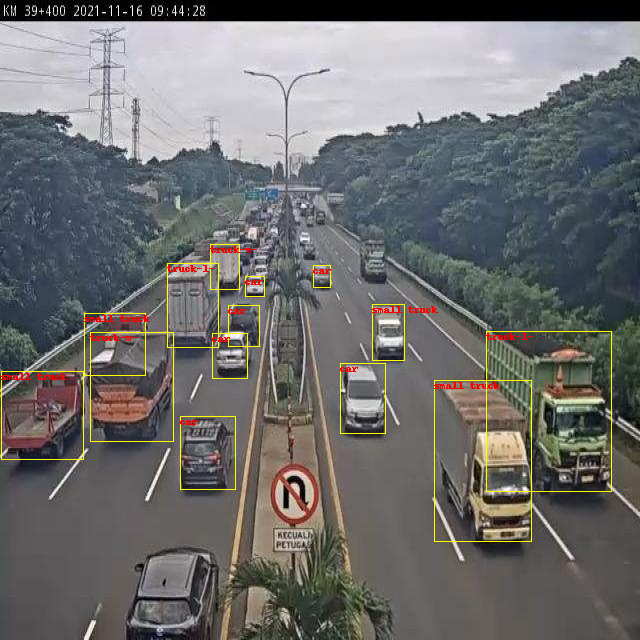

In [9]:
sample = data['train'][24]

sample_image = sample['image']
annotations = sample['objects']

draw = ImageDraw.Draw(sample_image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=1)
    draw.text((x, y), id2label[class_idx], fill="red")

sample_image

#### Basic Values/Constants

In [10]:
MODEL_CKPT = "hustvl/yolos-small"
MODEL_NAME = f'{MODEL_CKPT.split("/")[-1]}-Vehicle_Detection'

LR = 1e-5
WEIGHT_DECAY = 1e-4

NUM_OF_EPOCHS = 6

STRATEGY = "steps"
REPORTS_TO = "tensorboard"

#### Instantiate Image Processor

In [11]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


#### Define Some Transformations for Images

In [12]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=['category']),
)

#### Create Function to Reformat Annotations Correctly

In [13]:
def reformat_annotations(image_id, category, area, bbox):
    annotations = []
    for x in range(0, len(category)):
        new_annotation = {
            "image_id": image_id,
            "category_id": category[x],
            "isCrowd": 0,
            "area": area[x],
            "bbox": list(bbox[x]),
        }
        annotations.append(new_annotation)

    return annotations

#### Combine Image & Annotation Transformations For Use On Batch of Samples

In [14]:
def transform_image_ann(samples):
    image_ids = samples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(samples["image"], samples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        { "image_id": id_, "annotations": reformat_annotations(id_, cat_, ar_, box_)
        } for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images,
                           annotations=targets,
                           return_tensors="pt")

#### Apply Image Transformations to Training Dataset

In [15]:
data['train'] = data['train'].with_transform(transform_image_ann)

data['train'][24]

{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.5185, -1.5185, -1.5014,  ..., -1.2788, -1.2788, -1.2788],
          [-1.5185, -1.5185, -1.5014,  ..., -1.2788, -1.2788, -1.2788],
          [-1.5185, -1.5185, -1.5014,  ..., -1.2788, -1.2788, -1.2788]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.4055, -1.4055, -1.3880,  ..., -1.1954, -1.1954, -1.1954],
          [-1.4055, -1.4055, -1.3880,  ..., -1.2129, -1.1954, -1.1954],
          [-1.4055, -1.4055, -1.3880,  ..., -1.2129, -1.1954, -1.1954]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

#### Define Data Collator

In [16]:
def data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Define Model

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([14, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    MODEL_NAME,
    auto_find_batch_size=True,
    num_train_epochs=NUM_OF_EPOCHS,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    logging_steps=55,
    save_strategy=STRATEGY,
    save_steps=330,
    remove_unused_columns=False,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    fp16=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [19]:
trainer = Trainer(
    model,
    args=args,
    data_collator=data_collator_fn,
    train_dataset=data['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/yolos-small-Vehicle_Detection into local empty directory.


#### Train Model

In [20]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,3.021200
55,2.357500
110,1.961300
165,1.781400
220,1.702400
275,1.703500
330,1.628400
385,1.664100
440,1.607600
495,1.559800


TrainOutput(global_step=7902, training_loss=1.0911215363922255, metrics={'train_runtime': 9373.8968, 'train_samples_per_second': 1.686, 'train_steps_per_second': 0.843, 'total_flos': 5.58106536213504e+18, 'train_loss': 1.0911215363922255, 'epoch': 6.0})

#### Push Model To Hub

In [21]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/117M [00:00<?, ?B/s]

Upload file runs/Aug18_23-14-29_d8480d585499/events.out.tfevents.1692400482.d8480d585499.201.0:   0%|         …

To https://huggingface.co/DunnBC22/yolos-small-Vehicle_Detection
   8b26412..cb971de  main -> main

   8b26412..cb971de  main -> main

To https://huggingface.co/DunnBC22/yolos-small-Vehicle_Detection
   cb971de..a5133a8  main -> main

   cb971de..a5133a8  main -> main



'https://huggingface.co/DunnBC22/yolos-small-Vehicle_Detection/commit/cb971de91bbe070a335abe0932e0a95d8e84fd27'

#### Save Model

In [22]:
trainer.save_model()
trainer.save_state()

### Evaluate Model

#### Create Function to Reformat Evaluation Annotations Correctly

In [23]:
def eval_formatted_annotations(image_id, objects):
    annotations = []

    for x in range(0, len(objects["id"])):
        new_annotation = {
            "id": objects["id"][x],
            "category_id": objects["category"][x],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][x],
            "bbox": objects["bbox"][x],
        }
        annotations.append(new_annotation)

    return annotations

#### Save Images & Annotations into Proper Files

In [24]:
"""
Save images & annotations in format that
torchvision.datasets.CocoDetection expects
"""

def save_images_and_annotation_files(ds):
    output_json = {}
    path_output_ds = f"/Users/briandunn/Desktop/Object Detection/Hard Hat Detection/data/"

    if not os.path.exists(path_output_ds):
        os.makedirs(path_output_ds)

    path_annotation = os.path.join(path_output_ds, "nfl_annos.json")
    categories_json = [
        {"supercategory" : "none",
         "id": id,
         "name": id2label[id]
         } for id in id2label]
    output_json['images'] = []
    output_json['annotations'] = []

    for sample in ds:
        anno = eval_formatted_annotations(sample["image_id"],
                                          sample["objects"])
        output_json["images"].append(
            {
                "id": sample["image_id"],
                "width": sample["image"].width,
                "height": sample["image"].height,
                "file_name": f"{sample['image_id']}.png",
            }
        )
        output_json["annotations"].extend(anno)
    output_json["categories"] = categories_json

    with open(path_annotation, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(ds["image"], ds["image_id"]):
        path_image = os.path.join(path_output_ds, f"{img_id}.png")
        im.save(path_image)

    return path_output_ds, path_annotation

#### Create Class to Ingest Datasets

In [25]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, annot_file):
        super().__init__(img_folder, annot_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img,
                                          annotations=target,
                                          return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

#### Define Evaluation Data Collator

In [26]:
def eval_data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = eval_image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Apply Above Defined Functions to Validation Dataset

In [27]:
EVAL_MODEL_NAME = f'DunnBC22/yolos-small-Vehicle_Detection'

eval_image_processor = AutoImageProcessor.from_pretrained(EVAL_MODEL_NAME)

path_output_ds, path_annot = save_images_and_annotation_files(data["validation"])
eval_ds_coco_format = CocoDetection(path_output_ds,
                                    eval_image_processor,
                                    path_annot)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


#### Calculate Metrics

In [28]:
model = AutoModelForObjectDetection.from_pretrained(EVAL_MODEL_NAME)

module = evaluate.load("ybelkada/cocoevaluate",
                       coco=eval_ds_coco_format.coco)

eval_dataloader = torch.utils.data.DataLoader(
    eval_ds_coco_format,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=eval_data_collator_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(eval_dataloader)):
        pixel_values = batch["pixel_values"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]

        # forward pass
        outputs = model(pixel_values=pixel_values)

        orig_target_sizes = torch.stack(
            [
                target["orig_size"] for target in labels
            ],
            dim=0)

        results = eval_image_processor.post_process(outputs,
                                                    orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 58/58 [1:09:59<00:00, 72.41s/it]


Accumulating evaluation results...
DONE (t=0.77s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

#### Display Metrics

In [29]:
print(results)

{'iou_bbox': {'AP-IoU=0.50:0.95-area=all-maxDets=100': 0.08173100082609357, 'AP-IoU=0.50-area=all-maxDets=100': 0.17918645614155673, 'AP-IoU=0.75-area=all-maxDets=100': 0.059476227915603044, 'AP-IoU=0.50:0.95-area=small-maxDets=100': 0.02817660710893525, 'AP-IoU=0.50:0.95-area=medium-maxDets=100': 0.07305091477012096, 'AP-IoU=0.50:0.95-area=large-maxDets=100': 0.1986136538569331, 'AR-IoU=0.50:0.95-area=all-maxDets=1': 0.12659014099425495, 'AR-IoU=0.50:0.95-area=all-maxDets=10': 0.25457911397854593, 'AR-IoU=0.50:0.95-area=all-maxDets=100': 0.2761602019723671, 'AR-IoU=0.50:0.95-area=small-maxDets=100': 0.0668007066679633, 'AR-IoU=0.50:0.95-area=medium-maxDets=100': 0.24306037427604918, 'AR-IoU=0.50:0.95-area=large-maxDets=100': 0.5178697592455402}}


### Notes & Other Takeaways
****
- I probably should have fine tuned this model longer.

****

### Citations

- Model Checkpoint
    
    > @article{DBLP:journals/corr/abs-2106-00666, author = {Yuxin Fang and Bencheng Liao and Xinggang Wang and Jiemin Fang and Jiyang Qi and Rui Wu and Jianwei Niu and Wenyu Liu}, title = {You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection}, journal = {CoRR}, volume = {abs/2106.00666}, year = {2021}, url = {https://arxiv.org/abs/2106.00666}, eprinttype = {arXiv}, eprint = {2106.00666}, timestamp = {Fri, 29 Apr 2022 19:49:16 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2106-00666.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset

    > @inproceedings{inproceedings, author = {N J Karthika, Chandran Saravanan}, booktitle = {International Conference on Electronic Systems and Intelligent Computing (ESIC 2020)}, year = {2020}, month = {3), title = {Addressing False Positives in Pedestrian Detection}, doi = {https://doi.org/10.1007/978-981-15-7031-5_103}}